   PatientID  Gender  Age  CholesterolLevel  BloodPressure Region RiskCategory
0          1    Male   37             193.4          129.4   East         High
1          2  Female   45             210.7          107.1   West          Low
2          3    Male   63             244.3          103.9   West          Low
3          4    Male   53             184.5          127.2   West         High
4          5    Male   29             175.7          116.6  South         High
[ True  True  True  True]
Index(['PatientID', 'Age', 'CholesterolLevel', 'BloodPressure'], dtype='object')


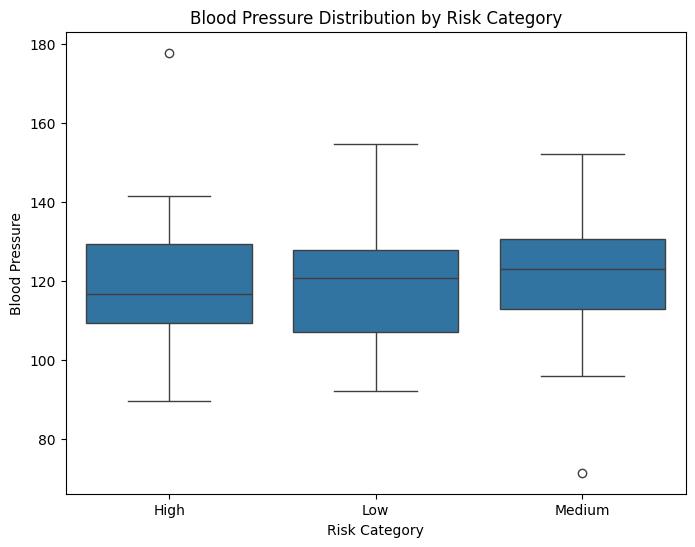

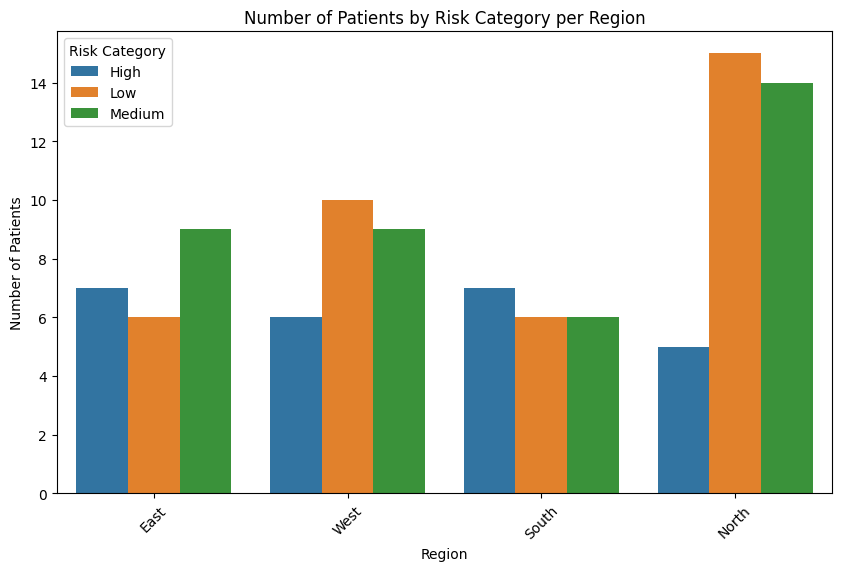

T-statistic: 0.5473367002699349
P-value: 0.5905194057676539
Fail to reject the null hypothesis: No significant difference from 200 mg/dL.
Chi-Square Statistic: 4.537654289304933
Degrees of Freedom: 6
P-value: 0.6043217060679176
Fail to reject the null hypothesis: No significant relationship between Region and RiskCategory.


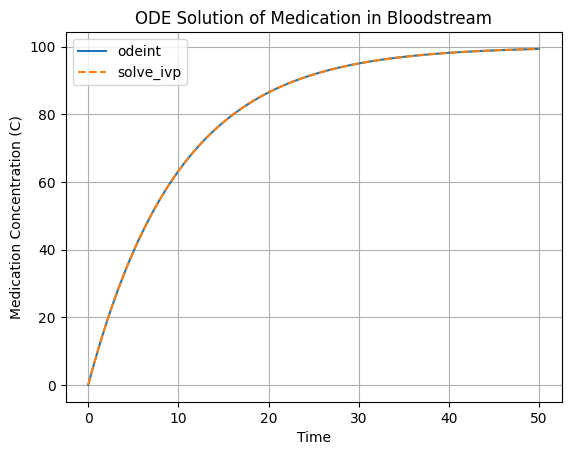

In [1]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_1samp
from scipy.stats import chi2_contingency
from scipy.integrate import odeint
from scipy.integrate import solve_ivp


df = pd.read_csv('patient_data.csv')
print(df.head())

numeric_data = df.select_dtypes(include='number') 
vares_thres = VarianceThreshold(threshold=0)
vares_thres.fit(numeric_data)
print(vares_thres.get_support())

print(numeric_data.columns[vares_thres.get_support()])

CholesterolLevel = numeric_data['CholesterolLevel']

def remove_outliers_zscore(df, column):
    threshold = 3
    mean = np.mean(df[column])
    std = np.std(df[column])
    zscore = (df[column] - mean) / std
    return df[abs(zscore) < threshold] 
df = remove_outliers_zscore(df, 'CholesterolLevel')

df.fillna(df.mean(numeric_only=True), inplace=True)

plt.figure(figsize=(8, 6))
sns.boxplot(x='RiskCategory', y='BloodPressure', data=df)
plt.title('Blood Pressure Distribution by Risk Category')
plt.xlabel('Risk Category')
plt.ylabel('Blood Pressure')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Region', hue='RiskCategory', data=df)
plt.title('Number of Patients by Risk Category per Region')
plt.xlabel('Region')
plt.ylabel('Number of Patients')
plt.legend(title='Risk Category')
plt.xticks(rotation=45)
plt.show()

sample = df['CholesterolLevel'].sample(20, random_state=42)

t_stat, p_val = ttest_1samp(sample, 200)

print("T-statistic:", t_stat)
print("P-value:", p_val)

if p_val < 0.05:
    print("Reject the null hypothesis: Average CholesterolLevel is significantly different from 200 mg/dL.")
else:
    print("Fail to reject the null hypothesis: No significant difference from 200 mg/dL.")

contingency_table = pd.crosstab(df['Region'], df['RiskCategory'])

chi2, p_val, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("Degrees of Freedom:", dof)
print("P-value:", p_val)

if p_val < 0.05:
    print("Reject the null hypothesis: There is a significant relationship between Region and RiskCategory.")
else:
    print("Fail to reject the null hypothesis: No significant relationship between Region and RiskCategory.")

def model(C, t, k, D):
    dCdt = k * (D - C)
    return dCdt

k = 0.1
D = 100
C0 = 0
t = np.linspace(0, 50, 100)

C_odeint = odeint(model, C0, t, args=(k, D))

plt.plot(t, C_odeint, label='odeint')

def model_ivp(t, C):
    return k * (D - C)

solution = solve_ivp(model_ivp, [0, 50], [C0], t_eval=t)

plt.plot(solution.t, solution.y[0], '--', label='solve_ivp')

plt.xlabel('Time')
plt.ylabel('Medication Concentration (C)')
plt.title('ODE Solution of Medication in Bloodstream')
plt.legend()
plt.grid(True)
plt.show()
